In [29]:
from util_fun import narx_sim_nrms, calculate_error_nrms, print_log
from model import Narx
from data import load_data, convert_to_narx, GS_Dataset, make_gs_dataset
import numpy as np
import pandas as pd
import sys
import torch
from sklearn.model_selection import train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass
from time import time, sleep
from datetime import timedelta
from os import path
import json


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
N_EPOCHS = 1000

In [30]:
params = {
    "n_a": [*range(3, 8)],
    "n_b": [*range(14, 26)],
    "n_layers": [1],
    "n_nodes": [50],
}

In [31]:
@dataclass
class GSResults:
    best_model: Narx = None
    best_sim_model: Narx = None
    best_nrms: float = None
    best_sim_nrms: float = None
    loss_list: list = None
    nrms_list: list = None
    sim_nrms_list: list = None

In [32]:
def train_narx_simval(
    model: Narx,
    n_a: int,
    n_b: int,
    data: GS_Dataset,
    log_file: str,
    param_msg: str = None,
    n_epochs: int = N_EPOCHS,
    device: torch.device = DEVICE,
):
    # initialise comparison values and results lists
    best_nrms = float("inf")
    best_model = None
    best_sim_nrms = float("inf")
    best_sim_model = None
    loss_list = []
    nrms_list = []
    sim_nrms_list = []

    # initialise checkpoints for validation
    checkpoints = [*range(0, n_epochs + 1, max(n_epochs // 25, 1))]
    if checkpoints[-1] != n_epochs-1:
        checkpoints += [n_epochs-1]

    # start training loop
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(n_epochs):
        loss = torch.mean((model(data.x_train) - data.y_train) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch in checkpoints:
            print_log(f"Checkpoint at epoch {epoch+1}: " + param_msg + " \n", log_file)
            # append loss to list, check prediction and simulation nrms
            loss_list.append(loss.item())

            nrms = calculate_error_nrms(model.forward(data.x_val), data.y_val)
            nrms_list.append(nrms)
            if nrms < best_nrms:
                print_log(
                    f"current pred NRMS: {nrms}, previous best pred NRMS: {best_nrms} \n",
                    log_file,
                )
                best_nrms = nrms
                best_model = deepcopy(model)

            _, _, _, sim_nrms = narx_sim_nrms(
                model, n_a, n_b, data.x_data, data.y_data, True, device, 
            )
            sim_nrms_list.append(sim_nrms)
            if sim_nrms < best_sim_nrms:
                print_log(
                    f"current sim NRMS: {sim_nrms}, previous best sim NRMS: {best_sim_nrms} \n",
                    log_file,
                )
                best_sim_nrms = sim_nrms
                best_sim_model = deepcopy(model)

    results = GSResults(
        best_model,
        best_sim_model,
        best_nrms,
        best_sim_nrms,
        loss_list,
        nrms_list,
        sim_nrms_list,
    )
    return results

In [33]:
def make_filename(filename,fileext=''):
    i = 0
    while path.exists(filename + str(i) + fileext):
        i += 1
    return filename + str(i) + fileext

def save_models(pred_model, sim_model,log_file=None):
    filename_sim=make_filename("narx_gs_best_sim")
    torch.save(sim_model.state_dict(),filename_sim)

    filename = make_filename("narx_gs_best_pred")
    torch.save(pred_model.state_dict(),filename)

    print_log(f'Saved best model in {filename}, best sim model in {filename_sim}', log_file)

In [34]:
results_dict = {}
device = DEVICE
n_epochs = N_EPOCHS
best_nrms = float("inf")
best_sim_nrms = float("inf")
best_model = None
best_sim_model = None
best_params = None
best_sim_params = None

grid_search_params = params
x, y = load_data()
total_runs = 1
for key in grid_search_params:
    total_runs *= len(grid_search_params[key])
run_counter = 0
start_time_list = []
log_file = make_filename('narx_gs_log','.txt')

print_log(f"Starting new Grid Search with parameters {grid_search_params} \n", log_file)
for i, n_a in enumerate(grid_search_params["n_a"]):
    for j, n_b in enumerate(grid_search_params["n_b"]):
        # n_a and n_b are the only two parameters that change the dataset
        data = make_gs_dataset(x, y, n_a, n_b, device)
        for k, n_nodes in enumerate(grid_search_params["n_nodes"]):
            for l, n_layers in enumerate(grid_search_params["n_layers"]):
                # general administration and timekeeping
                run_counter += 1
                start_time_list.append(time())
                param_string = f"{n_a=}, {n_b=}, {n_nodes=}, {n_layers=}"
                print_log(
                    f"Starting run {run_counter} out of {total_runs} \n", log_file
                )
                # generate model, do the actual training run, save the results
                model = Narx(n_a + n_b, n_nodes, n_layers).to(DEVICE)
                result = train_narx_simval(
                    model, n_a, n_b, data, log_file, param_string, n_epochs, device
                )
                results_dict[param_string] = result

                # check new results against old results, save if better
                if result.best_nrms < best_nrms:
                    print_log(
                        f"Found new best prediction model, with parameters {param_string} \n",
                        log_file,
                    )
                    print_log(
                        f"new best pred NRMS= {result.best_nrms}, previous best: {best_nrms} \n",
                        log_file,
                    )
                    best_nrms = result.best_nrms
                    best_model = deepcopy(result.best_model)
                    best_params = param_string
                if result.best_sim_nrms < best_sim_nrms:
                    print_log(
                        f"Found new best simulation model, with parameters {param_string} \n",
                        log_file,
                    )
                    print_log(
                        f"new best sim NRMS= {result.best_sim_nrms}, previous best: {best_sim_nrms} \n",
                        log_file,
                    )
                    best_sim_nrms = result.best_sim_nrms
                    best_sim_model = deepcopy(result.best_sim_model)
                    best_sim_params = param_string

                # finish the run
                run_time = timedelta(seconds=time() - start_time_list[-1])
                total_time = timedelta(seconds=time() - start_time_list[0])
                print_log(
                    f"Finished run {run_counter} out of {total_runs}. Time elapsed this run: {run_time}, total time elapsed: {total_time} \n",
                    log_file,
                )

print_log(
    f"Best prediction model found with parameters: {best_params}, and NRMS: {best_nrms}. \n "
    + f"Best simulation model found with parameters: {best_sim_params}, and NRMS: {best_sim_nrms}. \n"
    + f"Total time elapsed: {time()-start_time_list[0]} \n",
    log_file,
)
save_models(best_model, best_sim_model,log_file)
print(f'Run log saved in {log_file}')

Starting new Grid Search with parameters {'n_a': [3, 4, 5, 6, 7], 'n_b': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 'n_layers': [1], 'n_nodes': [50]} 

Starting run 1 out of 60 

Checkpoint at epoch 1: n_a=3, n_b=14, n_nodes=50, n_layers=1 

current pred NRMS: 1.0803147903622936, previous best pred NRMS: inf 

current sim NRMS: 1.0843791995575922, previous best sim NRMS: inf 

Checkpoint at epoch 41: n_a=3, n_b=14, n_nodes=50, n_layers=1 

current pred NRMS: 0.6775194974998564, previous best pred NRMS: 1.0803147903622936 

current sim NRMS: 0.7055427585454116, previous best sim NRMS: 1.0843791995575922 

Checkpoint at epoch 81: n_a=3, n_b=14, n_nodes=50, n_layers=1 

current pred NRMS: 0.5530152521634842, previous best pred NRMS: 0.6775194974998564 

current sim NRMS: 0.6890181253723139, previous best sim NRMS: 0.7055427585454116 

Checkpoint at epoch 121: n_a=3, n_b=14, n_nodes=50, n_layers=1 

current pred NRMS: 0.37543248096887216, previous best pred NRMS: 0.5530152521634842 

In [35]:
save_dict={}
for key in results_dict:
    temp_results=results_dict[key]
    save_dict[key]=(temp_results.nrms_list, temp_results.sim_nrms_list, temp_results.loss_list)

filename=make_filename('results_save','.json')

with open(filename,'w') as f:
    json.dump(save_dict,f)

print(f'results saved in {filename}')


results saved in results_save2.json


In [38]:
if False:   
    with open ('results_save1.json') as f:
        results_dict=json.load(f)
        
    na_list=params['n_a']
    nb_list=params['n_b']

    final_best_NRMSs = np.ndarray((len(na_list), len(nb_list)))
    simulation_NRMSs = np.ndarray((len(na_list), len(nb_list)))

    for i, n_a in enumerate(na_list):
        for j, n_b in enumerate(nb_list):
            temp_result=(results_dict[f'n_a={n_a}, n_b={n_b}, n_nodes=100, n_layers=1'])
            final_best_NRMSs[i,j]=min(temp_result[0])
            simulation_NRMSs[i, j]=min(temp_result[1])

else:
    na_list=params['n_a']
    nb_list=params['n_b']

    final_best_NRMSs = np.ndarray((len(na_list), len(nb_list)))
    simulation_NRMSs = np.ndarray((len(na_list), len(nb_list)))

    for i, n_a in enumerate(na_list):
        for j, n_b in enumerate(nb_list):
            temp_result:GSResults=(results_dict[f'n_a={n_a}, n_b={n_b}, n_nodes=50, n_layers=1'])
            final_best_NRMSs[i,j]=temp_result.best_nrms
            simulation_NRMSs[i, j]=temp_result.best_sim_nrms

filepred=make_filename('final_best_NRMSs')
filesim=make_filename('simulation_NRMSs')
np.savez(filepred, final_best_NRMSs)
np.savez(filesim, simulation_NRMSs)
print(f'{filepred = }, {filesim = }')

filepred = 'final_best_NRMSs0', filesim = 'simulation_NRMSs0'


C:\Users\Leo\AppData\Local\Temp\ipykernel_11240\2855414915.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([0] + na_list)
C:\Users\Leo\AppData\Local\Temp\ipykernel_11240\2855414915.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([0] + na_list)


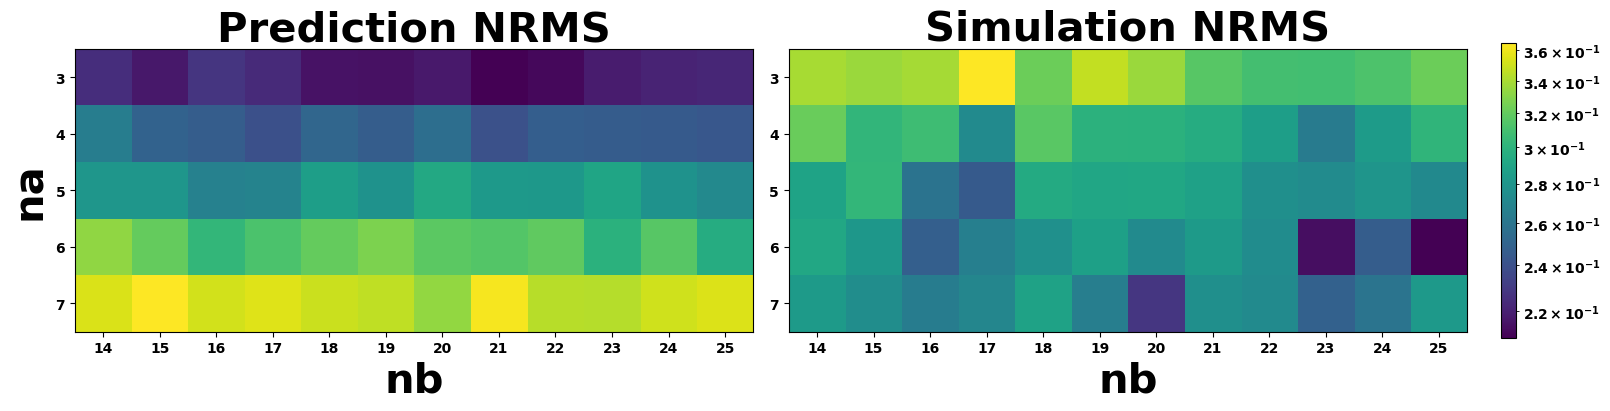

In [78]:
fs = 30
fig, axs = plt.subplots(1,2,figsize=(16, 5), layout="constrained") #,gridspec_kw={'width_ratios': [15,15,1],'height_ratios':[1]}
axs[0].imshow(final_best_NRMSs, interpolation="none", norm="log")
img=axs[1].imshow(simulation_NRMSs, interpolation="none", norm="log")
axs[0].set_title("Prediction NRMS", fontsize=fs)
axs[1].set_title("Simulation NRMS", fontsize=fs)
# fig.suptitle(
#     "Prediction and simulation NRMS for different combinations of na and nb for NARX",
#     fontsize=35, y=0.95
# )
axs[0].set_ylabel("na", fontsize=fs)
axs[0].set_xlabel("nb", fontsize=fs)
axs[1].set_xlabel("nb", fontsize=fs)
axs[0].set_yticklabels([0] + na_list)
axs[0].set_xticks([*range(len(nb_list))], nb_list)
axs[1].set_yticklabels([0] + na_list)
axs[1].set_xticks([*range(len(nb_list))], nb_list)
cbar=plt.colorbar(img,shrink=0.6)
plt.show()
if False:
    fig.savefig('narx_gs_simval2_1kepochs.png')
    fig.savefig('narx_gs_simval2_1kepochs.svg')